# Problem Set: Multi-Agent Prediction for Autonomous Driving (50pts)
## Due Monday, April 25, 11:59 p.m.

In this problem set, we will explore and implement critical elements of the multi-agent trajectory domain introduced in the lecture. In particular, we will implement an auto-labeling function to rapidly generate training data for a Graph Neural Net (GNN). Additionally, we will explore two critical elements of working with Graph Neural Nets. First, we will learn/implement the translation of a real-world multi-agent vehicle scenario into the graph domain. Secondly, we will encode data from this scenario as a PyTorch tensor than can be fed into a GNN.


1. [Auto-Labeling Pairwise Interactions](#autolabel)
  1. [Overview](#autolabel-overview)
  2. [Agent Modeling](#agent-modeling)
  3. [Automatic Data Labeling](#data-labeling)
3. [Graph Neural Nets](#gnn)
    1. [Creating A Graph Net](#graph-net)
    2. [Feature Encoding a Graph Net](#encoding)
        1. [Encoding Previous Motion States](#motion-state)
        2. [Encoding Node Types](#one-hot)
        3. [Encoding Graph Connectivity](#edge-list)
        4. [Creating A Graph Net Tensor](#tensor)
3. [Trajectory Prediction](#trajectory)

First, run the following cell to setup our environment.

In [80]:
%load_ext autoreload
%autoreload 2
!pip install shapely
!pip install matplotlib
!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu102.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu102.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.11.0+cu102.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
from grader import *
from helpers import *
import numpy as np
from shapely.geometry import LineString
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu102.html
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu102.html
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu102.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/sf/n0zklgcd1l73bbtc_s647z8h0000gn/T/pip-req-build-_megk4p9
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/sf/n0zklgcd1l73bbtc_s647z8h0000gn/T/pip-req-build-_megk4p9
  Created wheel for torch-geometric: filename=torch_geometric-2.0.5-cp37-none-any.whl size=628208 sha256=793f7ecf987b65279f05f664d3f74d884be040ba22808102697149d3bdfe1330
  Stored in directory: /private/var/folders/sf/n0zklgcd1l73bbtc_s647z8h0000gn/T/pip-ephem-wheel-cache-5pp4i3jc/wheels/f6/21/87/d338c1cb67a213a7a10393dec89ec0b19087ae0fdb3a94e0f2
Successfully built torch-geometric


## Auto-Labeling Pairwise Interactions (20pts) <a id="autolabel">

### Overview <a id="autolabel-overview">
    
We will begin by creating a dynamics model for our agent and using it to create a trajectory of states. Then, we will write a hueristic based labeling function that determines the interaction label between agents. 

### Agent Modeling (5pts) <a id="agent-modeling">

The state $s$ of the agent (autonomous vehicle) is represented by its 2D position ($x, y$) and velocity ($\dot{x}, \dot{y})$ at time $t$. We are interested in making predictions of the future states over the next $T$ seconds by considering the pairwise interactions between agents in the environment. 

To begin, we will examine the an example scenario where the vehicle's travel in a straight line at constant velocity, with no consideration of the other agents decisions. The following cell provides a `state` and `vehicle` class, and the dynamics of the vehicle are included in `update_state`.

You don't need to write code for the following cell, but it will helpful to familiarize yourself with the structure.

In [81]:
class State(object):
    def __init__(self, x, y, x_dot, y_dot, t):
        self.x = x
        self.y = y
        self.x_dot = x_dot
        self.y_dot = y_dot
        self.t = t
        
    def copy(self):
        return State(self.x, self.y, self.x_dot, self.y_dot, self.t)

class Agent(object):
    def __init__(self, x, y, x_dot, y_dot, t_0):
        self.initial_state = State(x, y, x_dot, y_dot, t_0)
        self.state = self.initial_state.copy()
    
    def update_state(self, dt):
        """Updates the state of the agent using its dynamics and a timestep.
    
        Input: dt - Timestep (elapsed time between the last state update)
        Output: Nothing, but updates self.state.
        """
        self.state.x = self.state.x + self.state.x_dot * dt
        self.state.y = self.state.y + self.state.y_dot * dt
        self.state.t = self.state.t + dt
        
    def reset_state(self):
        self.state = self.initial_state.copy()
    
    def get_state(self):
        return self.state.copy()

We need to determine the vehicles' trajectories for the next $T$ seconds. Use the Agent's update function to create an array of states of size $n$ that contains the discretized states $s_{t:t+T}$ 

In [82]:
def future_states(agent, T, n):
    """Captures the future states of an agent using its dynamics.
    
    Input: agent - vehicle agent class
           T - Capture states for the next T seconds, starting from the agent's current state
           n - The number of states to capture (the length of the state array)
    Output: An array of size n containing state predictions for the next T seconds.
    """
    agent.reset_state()
    future_state_array = [agent.get_state()]
    dt = T/N
    # YOUR CODE HERE
    for i in range(n):
        agent.update_state(dt)
        future_state_array.append(agent.get_state())
    return future_state_array

Run the following cell to check your implementation!

In [83]:
# Do not modify this cell!
agent_1 = Agent(5, 5, -1, -1, 0)
agent_2 = Agent(-5, 5, 1, -1, 0)
T = 6
N = 100
agent_state_array_1 = future_states(agent_1, T, N)
agent_state_array_2 = future_states(agent_2, T, N)

In [84]:
# Do not modify
check_agent_state_array(agent_state_array_1)
test_ok()

Tests passed!!

Let' examine what the trajectories look like for the initial states given above. Remember these vehicles are simply following a dynamically dictated trajectory with no consideration for other agents.

>Note: If the animations are broken, you will need to close out of the notebook and shut it down and then try again.

<IPython.core.display.Javascript object>


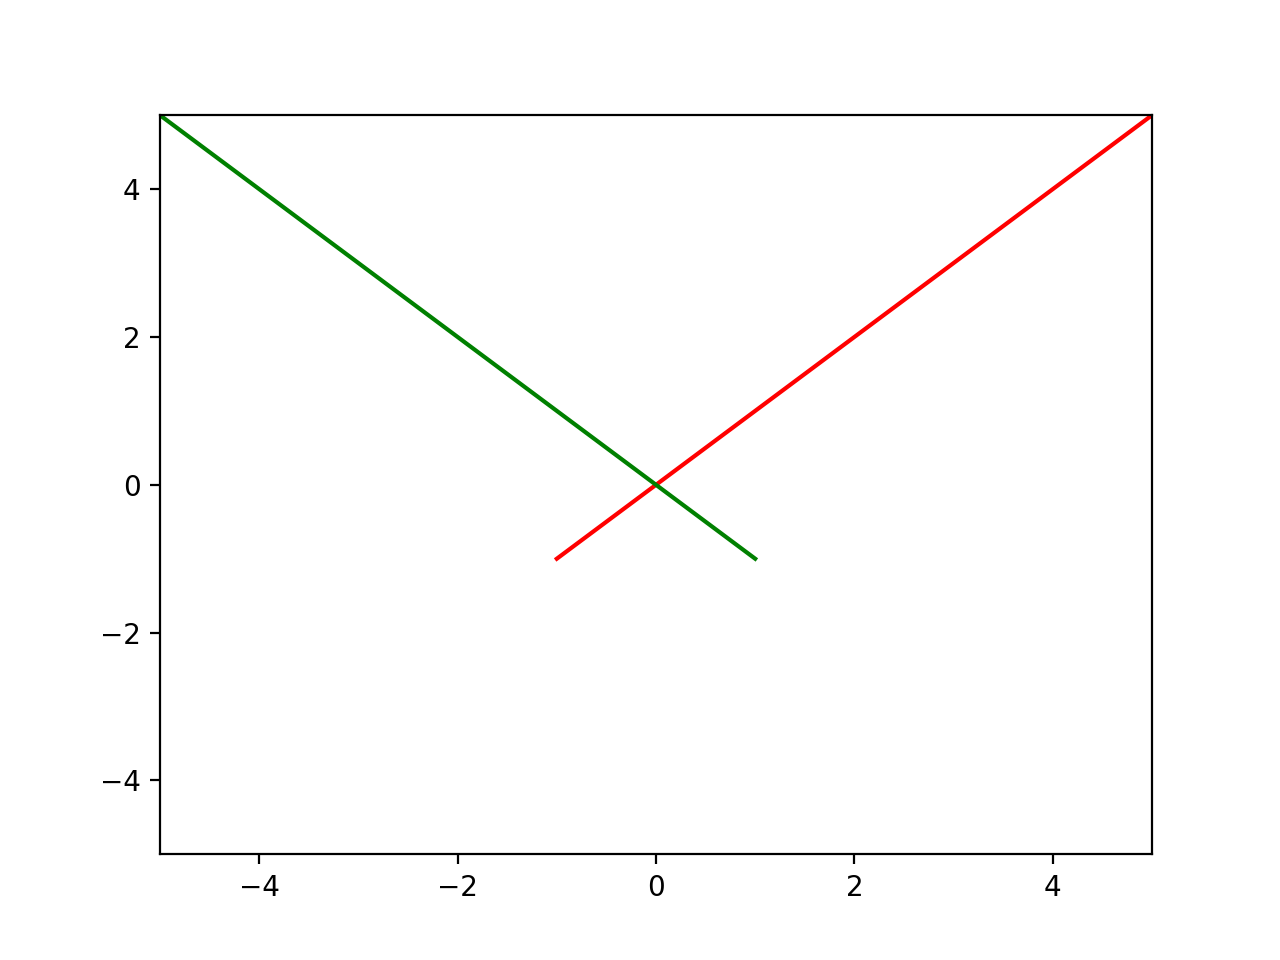

In [85]:
animate_trajectory(agent_state_array_1, agent_state_array_2)

Uh oh! The agent's have failed to account for eachother's behavior and collided! In the following sections, we will discuss a Graph Neural Network (GNN) structure as well as a training data generation scheme to allow agent's to learn interactions between eachother.

### Automatic Data Labeling (15pts) <a id="data-labeling">

In order for our Graph Neural Net (GNN) to learn interactions about other agents in the scene, it needs data to base its predictions off of - and lots of it. Obtaining a large amount of data is a tedious and time consuming process for a human expert. Instead, we will use a heuristic to automatically label data for us!

There are three types of interactions an agent can experience in a traffic scenario. Consider two agents $i$ and $j$.
* Agent $i$ is **GOING** with respect to agent $j$ if the trajectories of $i$ and $j$ intersect and $i$ arrived at the intersection point first.
* Agent $i$ is **YIELDING** with respect to agent $j$ if the trajectories of $i$ and $j$ intersect and $i$ arrived at the intersection point second.
* Agent $i$ is **IGNORING** with respect to agent $j$ if the trajectories of $i$ and $j$ do not intersect and $i$.

Let's investigate making this automatic labeling algorithm for the Agent model defined above!

To help you out, we have defined a number of helper classes and functions.

* The `LineSegment` class converts a pair of states into a line segment class that will be useful in determining intersections. This class simply creates a line segment (using shapely api) with endpoints defined by the positions of state 1 and 2.

* `convert_state_array_to_segment_array` takes in the output of your `future_states` function and converts it to a `LineSegment` array.

* `get_intersection_time` takes in two `LineSegment` objects. If they don't intersect, it returns `None, None`. If they do, it returns the time of intersection for `line_segment_1` and `line_segment_2`, respectively.

In [86]:
class LineSegment(object):
    def __init__(self, state_1, state_2):
        self.line_string = LineString([(state_1.x, state_1.y), (state_2.x, state_2.y)])
        self.t = (state_1.t, state_2.t)

In [87]:
def convert_state_array_to_segment_array(state_array):
    """
        Converts an array of states into an array of line segments.
    """
    line_segment_array = []
    for state_id in range(len(state_array) - 1):
        line_segment = LineSegment(state_array[state_id], state_array[state_id + 1])
        line_segment_array.append(line_segment)
    return line_segment_array

def get_intersection_point(line_segment_1, line_segment_2):
    line_string_1 = line_segment_1.line_string
    line_string_2 = line_segment_2.line_string
    intersection_point = line_string_1.intersection(line_string_2)
    if intersection_point.is_empty:
        return None
    return np.array(intersection_point.coords[0])

def get_intersection_time(line_segment, intersection_point):
    # Assume constant velocity so linear interpolation to get exact time.
    start_point = np.array(line_segment.line_string.coords[0])
    end_point = np.array(line_segment.line_string.coords[1])
    length_completed = np.linalg.norm((intersection_point - start_point))
    total_length = np.linalg.norm((end_point - start_point))
    
    start_time = line_segment.t[0]
    end_time = line_segment.t[1]
    total_time = end_time - start_time
    
    intersection_time = (length_completed / total_length) * total_time + start_time
    return intersection_time
    
def get_intersection_times(line_segment_1, line_segment_2):
    intersection_point = get_intersection_point(line_segment_1, line_segment_2)
    if intersection_point is None:
        return None, None
    
    time_1 = get_intersection_time(line_segment_1, intersection_point)
    time_2 = get_intersection_time(line_segment_2, intersection_point)
    
    return time_1, time_2

We have everything we need to start labeling data. Fill out the `classify_interaction` function, which takes two state arrays for agent 1 and 2.
>Hint: You will want to convert the state arrays into line segment arrays and iterate over all the line segments to see if any of the line segments intersect with eachother. If they do, you will be able to determine the interaction based on the insersection time for the 2 trajectories, using `get_intersection_time`!

In [88]:
def classify_interaction(agent_state_array_1, agent_state_array_2):
    """Computes the interation label between the 2 agents.
    
    Input: 
           agent_state_array_1 - Array of states for agent 1
           agent_state_array_2 - Array of states for agent 2
           
    Output: A string returning the interaction label of agent 1 with respect to agent 2.
            Output should either be GOING, YIELDING, or IGNORING.
    """
    # YOUR CODE HERE
    line_segment_array_1 = convert_state_array_to_segment_array(agent_state_array_1)
    line_segment_array_2 = convert_state_array_to_segment_array(agent_state_array_2)

    for line_segment_1 in line_segment_array_1:
        for line_segment_2 in line_segment_array_2:
            intersection_time_1, intersection_time_2 = get_intersection_times(line_segment_1, line_segment_2)
            if intersection_time_1 is None or intersection_time_2 is None:
                continue
            elif intersection_time_1 < intersection_time_2:
                return "GOING"
            elif intersection_time_1 >= intersection_time_2:
                return "YIELDING"
    return "IGNORING"

Run the following cells to test your implementation! The red trajectory is agent_1 and the green is agent_2!

Tests passed!!

GOING


<IPython.core.display.Javascript object>


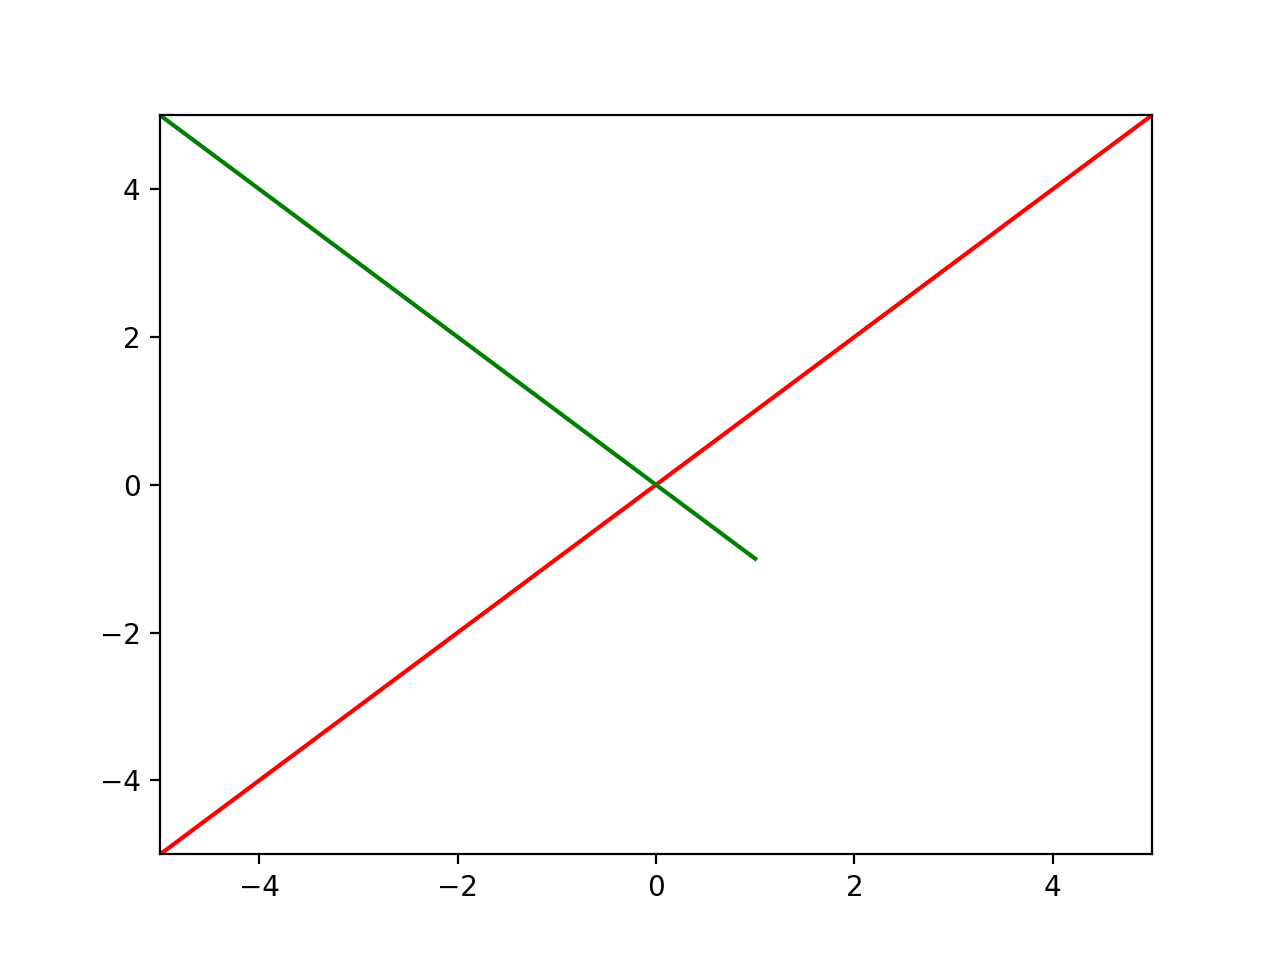

In [89]:
# Do not modify
agent_1 = Agent(5, 5, -2, -2, 0)
agent_2 = Agent(-5, 5, 1, -1, 0)
T = 6
N = 100
agent_state_array_1 = future_states(agent_1, T, N)
agent_state_array_2 = future_states(agent_2, T, N)
label = classify_interaction(agent_state_array_1, agent_state_array_2)
check_interaction_label_1(label)
test_ok()
print(label)
animate_trajectory(agent_state_array_1, agent_state_array_2)

Tests passed!!

YIELDING


<IPython.core.display.Javascript object>


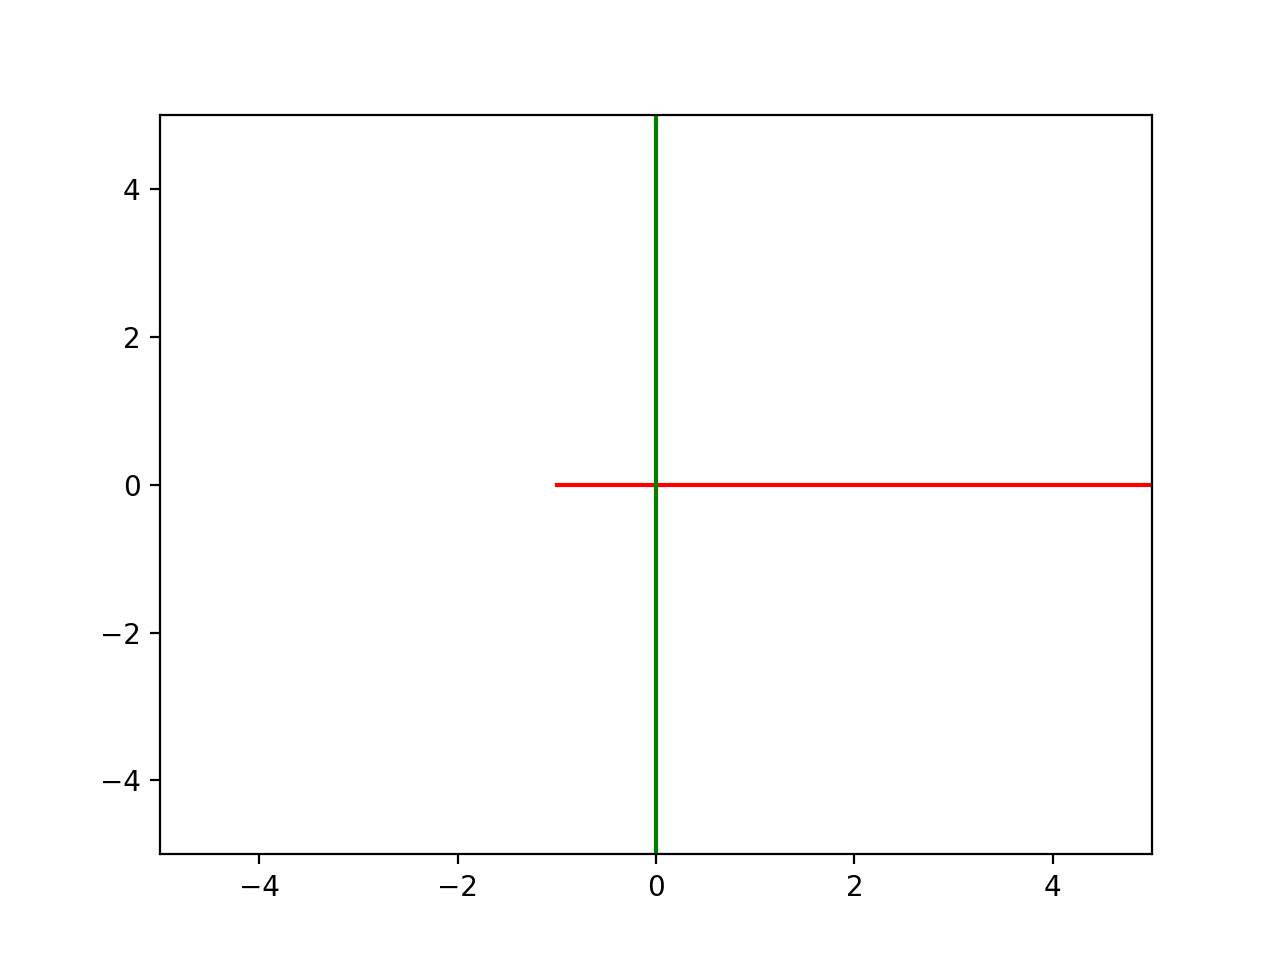

In [90]:
# Do not modify
agent_1 = Agent(5, 0, -1, 0, 0)
agent_2 = Agent(0, -5, 0, 2, 0)
T = 6
N = 100
agent_state_array_1 = future_states(agent_1, T, N)
agent_state_array_2 = future_states(agent_2, T, N)
label = classify_interaction(agent_state_array_1, agent_state_array_2)
check_interaction_label_2(label)
test_ok()
print(label)
animate_trajectory(agent_state_array_1, agent_state_array_2)

Tests passed!!

IGNORING


<IPython.core.display.Javascript object>


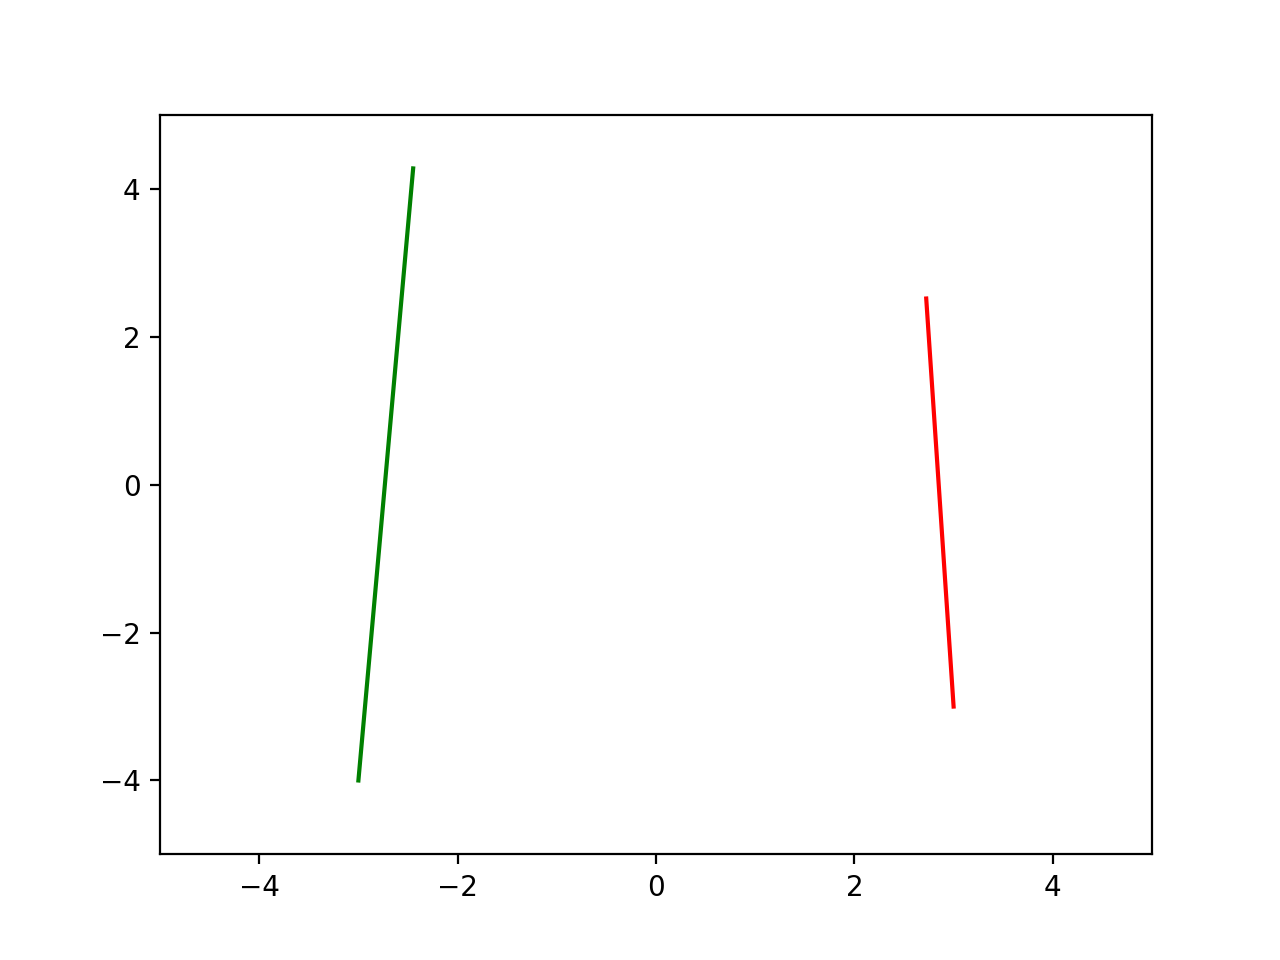

In [102]:
# Do not modify
agent_1 = Agent(3, -3, -0.1, 2, 0)
agent_2 = Agent(-3, -4, 0.2, 3, 0)
T = 6
N = 100
agent_state_array_1 = future_states(agent_1, T, N)
agent_state_array_2 = future_states(agent_2, T, N)
label = classify_interaction(agent_state_array_1, agent_state_array_2)
check_interaction_label_3(label)
test_ok()
print(label)
animate_trajectory(agent_state_array_1, agent_state_array_2)

# Graph Neural Nets (GNN) (25pts) <a id="gnn"/>

In the image below, we have a multi-agent autonomous driving scenario involving four vehicles, which we will call **traffic actors**, and two traffic controls in the form of stop signs which we will call **traffic elements**.

![intersection-image](intersection.png)

If we recall from the lecture, this intersection scenario can be converted into a graph structure called a **Hybrid Graph**. A hybrid graph will translate the interactions of the intersection into a graph that reflects the general structure of the scenario. The hybrid graph adheres to the following rules:

- Traffic actors and traffic elements are nodes N in our graph G(V,E)
- Edges denote interactions between traffic actors and traffic elements
- Edges are directed so if A and B are connected then an edge (A,B) and (B,A) must be created
- All traffic actors are connected to one another
- A traffic actor and a traffic element are connect if they are within **20** meters of each other

## Creating A Graph Net (10pts) <a id="graph-net"/>

NetworkX Documentation (refresher): 
https://networkx.org/documentation/stable/reference/classes/digraph.html

For this problem we will be using the **networkX** library which we used in PSET1 to create a **Graph Net** (a grap representation) that models the multi-agent intersection described above.

Use the following variables as the node names:

- BlueCar : **B**
- LimeCar: **L**
- PoliceCar: **P**
- GreenCar: **G**
- Nearest Stop Sign from 0: **S1**
- Second Stop Sign: **S2**

<IPython.core.display.Javascript object>


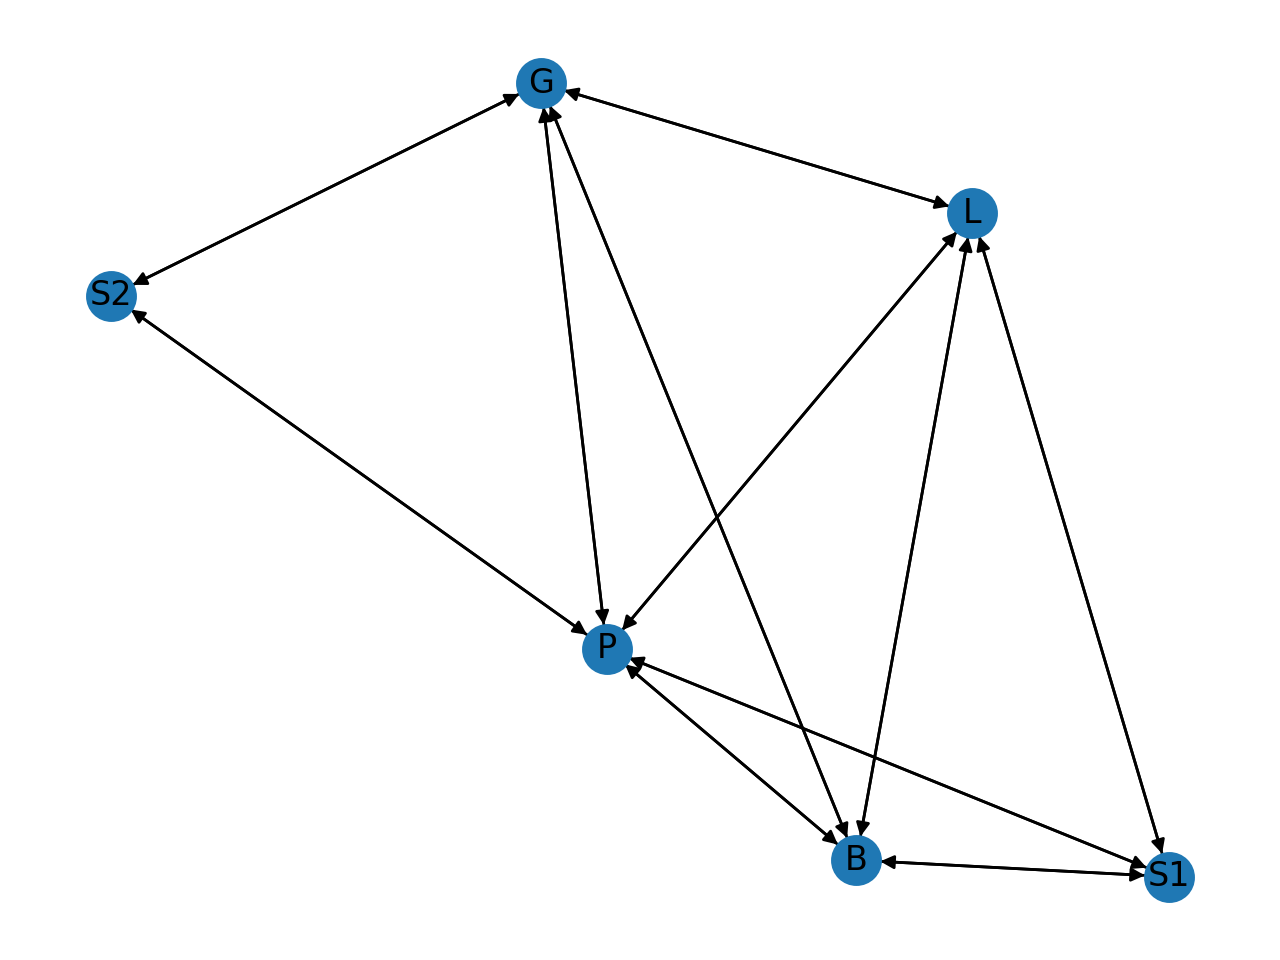

Tests passed!!

In [103]:
def create_intersection_graph_net():
    """
    Models the multi-agent intersection as a graph
    
    Output: A NetworkX DiGraph with nodes and edges that reflect the traffic scenario described above
    """
    intersection_graph_net = nx.DiGraph() 
    #TODO: Add the nodes and edges to the the graph intersection_graph_net
    
    #Add Traffic Actors and Traffic Elements
    intersection_graph_net.add_node("B")
    intersection_graph_net.add_node("G")
    intersection_graph_net.add_node("L")
    intersection_graph_net.add_node("P")
    intersection_graph_net.add_node("S1")
    intersection_graph_net.add_node("S2")
    
    #Blue Car
    intersection_graph_net.add_edge("B","L")
    intersection_graph_net.add_edge("L","B")
    intersection_graph_net.add_edge("B","G")
    intersection_graph_net.add_edge("G","B")
    intersection_graph_net.add_edge("B","P")
    intersection_graph_net.add_edge("P","B")
    intersection_graph_net.add_edge("B","S1")
    intersection_graph_net.add_edge("S1","B")
    
    #Lime Car
    intersection_graph_net.add_edge("L","P")
    intersection_graph_net.add_edge("P","L")
    intersection_graph_net.add_edge("L","G")
    intersection_graph_net.add_edge("G","L")
    intersection_graph_net.add_edge("L","S1")
    intersection_graph_net.add_edge("S1","L")
    
    #Police Car
    intersection_graph_net.add_edge("P","G")
    intersection_graph_net.add_edge("G","P")
    intersection_graph_net.add_edge("P","S1")
    intersection_graph_net.add_edge("S1","P")
    intersection_graph_net.add_edge("P","S2")
    intersection_graph_net.add_edge("S2","P")
    
    #Green Car
    intersection_graph_net.add_edge("G","S2")
    intersection_graph_net.add_edge("S2","G")
    
    return intersection_graph_net


G = create_intersection_graph_net()

# Uncomment the code below to visualize your graph\
fig = plt.figure()
nx.draw(G, with_labels = True)
plt.show()

#Test Case - DO NOT MODIFY
check_create_intersection_graph_net(G)

## Feature Encoding of A GraphNet (15pts) <a id="encoding"/>

In the previous probelm we converted our multi-agent intersection into a basic Graph Net (GN) structure. In this part we will now learn how to encode the features of each node into a matrix or **tensor** that will be feed into our Graph Neural Net (GNN)

If we recall from lecture a given traffic agent or node in our graph has the following features:

![graph-node](graph-node.png)


In this probelm we will simplify the node level features to the first two:

- **Node Type** (One Hot Encoding)
- **Past Motion States** (fixed horizion)


If we recall from lecture or goal is to combine our **node type, past motion, and graph connectivty** into an encoding/tensor that will define our intial input $h_0$ into our GNN

$$h_i = f_{l} \Bigg(v_i,h_{i}^{s} \Bigg)$$


Below are the tables providing the past motion states for each traffic agent and traffic element:

| Green Car Features |     |     |          |
| :----------------- | :-- | :-- | :------- |
| Time Step          |  X  | Y   | Velocity |
| t-1                | 52  | 37  | 4        |
| t-2                | 54  | 37  | 4        |
| t-3                | 57  | 37  | 6        |
| t-4                | 60  | 37  | 6        |



| Police Car Features |     |     |          |
| :------------------ | :-- | :-- | :------- |
| Time Step           |  X  | Y   | Velocity |
| t-1                 | 38  | 30  | 16       |
| t-2                 | 38  | 22  | 16       |
| t-3                 | 38  | 14  | 16       |
| t-4                 | 38  | 4   | 16       |


| Lime Car Features |     |     |          |
| :------------------ | :-- | :-- | :------- |
| Time Step           |  X  | Y   | Velocity |
| t-1                 | 18  | 32  | 4       |
| t-2                 | 16  | 32  | 4       |
| t-3                 | 13  | 32  | 6       |
| t-4                 | 9   | 32  | 6       |


| Blue Car Features |     |     |          |
| :------------------ | :-- | :-- | :------- |
| Time Step           |  X  | Y   | Velocity |
| t-1                 | 9  | 32  | 2      |
| t-2                 | 8  | 32  | 2       |
| t-3                 | 6  | 32  | 4       |
| t-4                 | 3  | 32  | 6       |


| Stop Sign 1 Features |     |     |          |
| :------------------ | :-- | :-- | :------- |
| Time Step           |  X  | Y   | Velocity |
| t-1                 | 28  | 28  | 0      |
| t-2                 | 28  | 28  | 0       |
| t-3                 | 28  | 28  | 0       |
| t-4                 | 28  | 28  | 0       |

| Stop Sign 2 Features |     |     |          |
| :------------------ | :-- | :-- | :------- |
| Time Step           |  X  | Y   | Velocity |
| t-1                 | 42  | 42  | 0      |
| t-2                 | 42  | 42  | 0       |
| t-3                 | 42  | 42  | 0       |
| t-4                 | 42  | 42  | 0       |

#### Given This infromation we will create an input tensor for a GNN in three steps:

1. Create Previous Motion State Vector
2. One Hot Encode Node Type
3. Create Edge List Matrix

### 1. Create Previous Motion State Vector (5pts)  <a id="motion-state"/>

Our first objective is to translate the previous motion state information for each vehicle into a matrix. We ask that you adhered to the following convention:
- Rows: time steps
- Columns: features

In [93]:
#TODO - define previous motion state for the blue car
blue_car_prior_state = np.array([[9,32,2],[8,32,2],[6,32,4],[3,32,6]])

#TODO - define previous motion state for the lime car
lime_car_prior_state = np.array([[18,32,4],[16,32,4],[13,32,6],[9,32,8]])

#TODO - define previous motion state for the police car
police_car_prior_state = np.array([[38,30,16],[38,22,16],[38,14,16],[38,6,16]])

#TODO - define previous motion state for the green car
green_car_prior_state = np.array([[50,37,2],[53,37,7],[58,37,10],[60,37,12]])

#TODO - define previous motion state for the stop sign 1
stop_sign_1_prior_state = np.array([[28,28,0],[28,28,0],[28,28,0],[28,28,0]])

#TODO - define previous motion state for the stop sign 2
stop_sign_2_prior_state = np.array([[42,42,0],[42,42,0],[42,42,0],[42,42,0]])

#Test Case - DO NOT MODIFY
test_ok_green_car_prior_state(green_car_prior_state)
test_ok_police_car_prior_state(police_car_prior_state)
test_ok_lime_car_prior_state(lime_car_prior_state)
test_ok_blue_car_prior_state(blue_car_prior_state)
test_ok_stop_sign_1_prior_state(stop_sign_1_prior_state)
test_ok_stop_sign_2_prior_state(stop_sign_2_prior_state)

Tests passed!!

Tests passed!!

Tests passed!!

Tests passed!!

Tests passed!!

Tests passed!!

### 2. One Hot Encoding Node Type (2pts) <a id="one-hot"/>

Remember from lecture that in the TrafficNet Hybrid Graph we have a combination of seven different traffic actors and traffic elements 

- Vehicles
- Stop Signs
- Yield Signs
- Red traffic lights
- Yellow traffic lights
- Green traffic lights
- Unknown traffic lights

In the following part we create a function that does a one hot encoding for the actors/elements present in our multi-agenet scenario described above.

If you are not familar with one hot encoding refer here:
https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f


In [94]:
def one_hot_encode_node_type(node_type):
    """
    Encodes our node types into a one hot encoding that adhears to the following ordering convention
    [vehicle, stop, yield, red, yellow, green, unknown]
    
    Input: node_type - a string of the node type
    Output: A one hot encoding of the node_type as an np array vector with dimentions 1 x 7
    """
    template = ["vehicle", "stop", "yield", "red", "yellow", "green", "unknown"]
    base = [0,0,0,0,0,0,0]
    base[template.index(node_type)] = 1
    return base

#Test Cases - DO NOT MODIFY
test_ok_one_hot_encode_node_type_vehicle(one_hot_encode_node_type("vehicle"))
test_ok_one_hot_encode_node_type_stop_sign(one_hot_encode_node_type("stop"))

Tests passed!!

Tests passed!!

### 3. Create Edge List Matrix (3pts) <a id="edge-list"/>

The final elements we need to create our tensor is a data structure to define the connectivity of our graph. Many of you will be familair with the concept of an adjaceny matrix:

![adj-matrix](adjmatrix.png)

The issue that arises with an adjaceny matrix is that often times the amount of nodes far out number the amount of edges causing our matrix to be **sparse**, as seen by all the 0s in the example above. Sparse matrices are undesirable  ecause are space inefficent. Thus we will use another data structure called an **edge list**. 

An edge list is a   **2 x |E|**   matrix where the first row defines the **from** nodes and the second row defines the **to** nodes.


![example_graph](example_graph.png)


The edge list for the example above would be:

$
\begin{bmatrix}
1 & 2 & 1 & 3 & 2 & 3\\
2 & 1 & 3 & 1 & 3 & 2
\end{bmatrix}
$

Below we will define the edge list for our GraphNet we defined above. Because we want to work soley with numbers in our edge matrix we will make the following conversion in naming convention

- BlueCar : **0**
- LimeCar: **1**
- PoliceCar: **2**
- GreenCar: **3**
- Nearest Stop Sign: **4**
- Second Stop Sign: **5**

In [95]:
edge_list = np.array([[0,1,0,2,0,3,0,4,1,2,1,3,1,4,2,3,2,4,2,5,3,5],
                                             [1,0,2,0,3,0,4,0,2,1,3,1,4,1,3,2,4,2,5,2,5,3]])

#Test Cases - DO NOT MODIFY
check_intersection_graph_net_edge_list(edge_list)

Tests passed!!

### Creating A Graph Net Tensor (5pts)  <a id="tensor"/>

Now that we have intialized the building blocks that will define our GraphNet feature tensor we will now combine each encoding to achive the follwoing transformation 

$$h_i = f_{l} \Bigg(v_i,h_{i}^{s} \Bigg)$$

In order to do so we will be using that pytorch library, in particular the pytorch geometric library which is specialized to work with Graph Nets (GN) and Graph Neural Nets (GNN).

In [96]:
#DO NOT MODIFY
node_type_list = ["vehicle","vehicle","vehicle","vehicle","stop","stop"]
                                
def create_graph_tensor(blue_car_prior_state,lime_car_prior_state,police_car_prior_state,green_car_prior_state,
                        stop_sign_1_prior_state,stop_sign_2_prior_state, node_type_list, edge_list):
    
    """
    Creates a pytorch geometric data tensor from our graph featue encodings"
    
    Input: 
        blue_car_prior_state - previous state matrix defined in part 1
        lime_car_prior_state - previous state matrix defined in part 1
        police_car_prior_state - previous state matrix defined in part 1
        green_car_prior_state - previous state matrix defined in part 1
        stop_sign_1_prior_state - previous state matrix defined in part 1
        stop_sign_2_prior_state - previous state matrix defined in part 1
        node_type_list - a 1 x 7 array of the node types ie: ["red", "stop", "vehicle" .... ]
        edge_list - a [2 x |E|] edge list for the Graph Net
        
    Output: A pytorch geometric Data tensor
    """
    
    #DO NOT MODIFY
    combined_previous_state_matrices = np.array([blue_car_prior_state.flatten(), 
                         lime_car_prior_state.flatten(),
                         police_car_prior_state.flatten(),
                         green_car_prior_state.flatten(), 
                         stop_sign_1_prior_state.flatten(),
                         stop_sign_2_prior_state.flatten()])
       
    
    #TODO: For each element in the node_type_list convert it into its one hot encoding
    node_encoding_vector = np.array([one_hot_encode_node_type(i) for i in node_type_list])
                                                
    #TODO convert the node_encoding_vector into a pytorch tensor (very simple!)
    node_encoding_tensor = torch.tensor([node_encoding_vector])
                                                
    previous_state_tensor = torch.tensor([combined_previous_state_matrices])
    edge_list_tensor = torch.tensor([edge_list])
                                                
    
    #raise NotImplementedError
    return Data(x=previous_state_tensor, y=node_encoding_tensor, edge_index=edge_list_tensor)

data_tensor = create_graph_tensor(blue_car_prior_state,lime_car_prior_state,police_car_prior_state,green_car_prior_state,
                        stop_sign_1_prior_state,stop_sign_2_prior_state,node_type_list, edge_list) 

#Test Cases - DO NOT MODIFY
check_data_tensor(data_tensor)

Tests passed!!

## Trajectory Prediction (5pts) <a id="trajectory">

The main goal we have for formulating graph neural nets is to utilize them in order to solve multi-agent trajectory prediction problems. The model that can do this involves a "typed" GNN, with edges typed according to the interaction type between modes, and a recurrent module, which is able to rollout future states. This model is able to predict the next state of the objects which the nodes in the graph represent and does so through a series of steps, including computing edge embeddings, updating nodes with incoming messages, and updating the node embeddings. In this problem, we will focus just on the final step of the process, which involves predicting the next state. The formula that describes this prediction is 
$$ \hat{s_i}^{(t)}, h_i^{(t)0} = r(s_i^{t-1}, h_i^{(t-1)N}) $$
where $h_i^{(t-1)N}$ is the node embedding of node i in the final layer at timestep t-1, r is the recurrent network, and $s_i^{t-1}$ is the state of node i at timestep t-1.  

Given a list of states so far, a recurrent network, and the node embedding at the final layer, find the current state $\hat{s_i}^{(t)}$ of a node in this simplified example:

In [97]:
def get_node_current_state(recurrent_network, states, final_layer_embedding):
    """
    recurrent_network = a function representing an RNN, takes in two arguments: state history and final node embedding, returns one argument: current predicted state
    states = a list of the history of the states node i has gone through
    final_layer_embedding = the embedding of node i in the final layer of the graph at timestep t-1
    """
    return recurrent_network(states, final_layer_embedding)

In [98]:
#Test Cases - DO NOT MODIFY
check_trajectory_prediction(get_node_current_state)

Tests passed!!